In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

name = "peregrine_boi"

p = os.path.abspath(f"../doctors/{name}/")

w_in = np.load(os.path.join(p, "w_in.npy"))
w = np.load(os.path.join(p, "w.npy"))
w_out = np.load(os.path.join(p, "w_out.npy"))
neurons = np.load(os.path.join(p, "neurons.npy")).T

print("W_in", "max", "mean", "sd")
print(np.max(np.abs(w_in)), np.mean(w_in), np.std(w_in))

print("W", "max", "mean", "sd")
print(np.max(np.abs(w)), np.mean(w), np.std(w))

print("W_out", "max", "mean", "sd")
print(np.max(np.abs(w_out)), np.mean(w_out), np.std(w_out))

W_in max mean sd
0.3827951709877154 0.0010941707405593758 0.09258491068540814
W max mean sd
0.4050978585363693 -0.0004087808246893555 0.09395104978711032
W_out max mean sd
3.100007983337384 -0.01670369878297309 0.8013204954315042


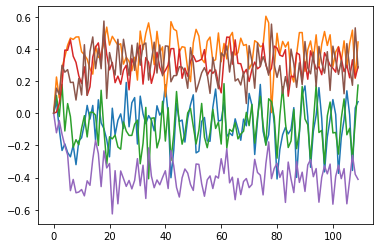

In [4]:
n = np.arange(neurons.shape[1])

indicies = n < 110

plt.plot(n[indicies], neurons[0][indicies])
plt.plot(n[indicies], neurons[1][indicies])
plt.plot(n[indicies], neurons[2][indicies])
plt.plot(n[indicies], neurons[3][indicies])
plt.plot(n[indicies], neurons[4][indicies])
plt.plot(n[indicies], neurons[5][indicies])


In [ ]:
ys = np.load("../trash/ys.npy")
yhats = np.load("../trash/yhats.npy")


delta = np.mean((yhats - ys) * (yhats - ys), axis=0)
variances = np.var(ys, axis=0)
NMSE = delta / variances
NRMSE = np.sqrt(NMSE)
NRMSE = np.mean(NRMSE)